In [1]:
%env MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij
import os
import base64
import matplotlib.pyplot as plt
from mistralai import Mistral
import json
import pandas as pd
from typing import Union
import numpy as np
import secrets

pd.set_option('display.max_colwidth', None)
# Load Mistral API key from environment variables
api_key = os.environ["MISTRAL_API_KEY"]

# Initialize the Mistral client
client = Mistral(api_key=api_key)

env: MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij


In [ ]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(args): 
    image_base64, guide = args
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}, "
                    "{\"element\": \"some name for element2\", ...}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with an image of an outfit, describe each of the elements thanks to your expertise "
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def process_critique(args):
    outfit, guide = args
    
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=[
            {"role": "system", "content": "As a 'Fashion Critique', your mission is to help relook people. \n\n {guide} \n\n You are given a description of items in an outfit. Give a critique of the outfit, outlining the general vibe, how the pieces work together and what could be improved."},
            {"role": "user", "content": outfit},
        ],
        temperature=0.2,
        max_tokens=2048
    )
    result = chat_response.choices[0].message.content

    return result

def recommend_item(critique, guide, color_rule, piece_rule): 
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some short name for element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit, shape of element1. Be concise.\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"a word describing the occasion, mood or functionality of the piece\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece and that encapsulates the precedent variables\"}]}"
        },
        {
            "role": "system",
            "content": f"You are a fashion critique, neutral and objective.\n\n {guide} \n\n You are presented with a critique of an outfit, describe a single element that would improve the outfit."
        },
        {
            "role": "system",
            "content": "Follow this rule when suggesting a piece of clothing: " + piece_rule
        },
        {
            "role": "system",
            "content": "Follow this rule when choosing a color: " + color_rule
        },
        {
            "role": "user",
            "content": critique
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=messages,
        temperature=0.4,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def save_df(clothes_df, reco_df):
    random_hash = secrets.token_hex(4)
    clothes_df.to_pickle(f"./data/clothes_{random_hash}.pkl")
    reco_df.to_pickle(f"./data/reco_{random_hash}.pkl")

def load_df(hash):
    clothes_df = pd.read_pickle(f"./data/clothes_{hash}.pkl")
    reco_df = pd.read_pickle(f"./data/reco_{hash}.pkl")
    
    return clothes_df, reco_df

In [3]:
desc_guide_path = "./desc_guide.txt"
critique_guide_path = "./critique_guide.txt"

with open(critique_guide_path, "rb") as f:
    critique_guide = f.read()

with open(desc_guide_path, "r") as f:
    desc_guide = f.read()

,element,color,fit,price,context,description
0,Asymmetric Collar Jacket,Black,Oversized with an asymmetric collar and draped design,Estimated $200,Urban street style,"This black jacket features an asymmetric collar and a draped design, giving it a unique and stylish edge. The oversized fit makes it perfect for layering over other pieces, adding a touch of sophistication to any urban ensemble."
1,Skinny Leggings,Black,Form-fitting with a slight sheen,Estimated $50,Urban street style,"These black skinny leggings have a slight sheen and a form-fitting cut, providing both comfort and style. They complement the jacket perfectly, creating a cohesive and trendy look suitable for an urban setting."
2,Block Heeled Ankle Boots,Black,Sleek and ankle-length with a chunky block heel,Estimated $150,Urban street style,"These black ankle boots feature a sleek design and a chunky block heel, offering both comfort and a modern aesthetic. They complete the outfit, adding a touch of sophistication and edge to the overall look."
3,Shopping Bag,White,Large with minimal branding,Estimated $20,"Casual, everyday use","This white shopping bag has a minimalist design with subtle branding, making it a practical and stylish accessory for everyday use. It complements the urban street style of the outfit without drawing attention away from the main pieces."


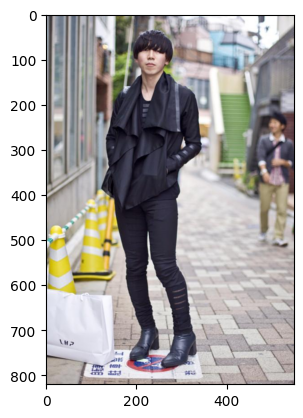

In [12]:
img_path = f"C:/Users/bapti/Documents/DATA/Cours/3A/Hackathon/fashion_images_dataset/0056.jpg"
plt.imshow(plt.imread(img_path))

img_64 = img_to_base64(img_path)
clothes = list_clothes((img_64, desc_guide))
clothes_df = json_to_dataframe(clothes, key='elements')
clothes_df

In [13]:
outfit = '-'+'\n-'.join(clothes_df['description'])
critique = process_critique((outfit, critique_guide))
print(critique)

**Outfit Critique**

**General Vibe:** The outfit exudes a chic, urban street style with a monochromatic color scheme. It's sleek and sophisticated with a modern edge, perfect for a trendy city look.

**How the Pieces Work Together:**

- The black jacket and black skinny leggings create a seamless base for the outfit. The jacket's asymmetric collar and draped design add a touch of uniqueness, while the leggings' slight sheen provides a subtle contrast in texture.
- The black ankle boots complement the outfit well, continuing the monochromatic theme and adding a touch of sophistication with their sleek design and chunky block heel.
- The white shopping bag acts as a neutral accessory, balancing the all-black ensemble without disrupting the flow of the outfit. Its minimalist design fits well with the urban street style.

**What Could Be Improved:**

- **Add a Pop of Color:** While the monochromatic look is chic, adding a pop of color could bring more vibrancy and personalization to the o

In [14]:
reco_df=[]
n_suggest = 3
color_rules = np.random.choice([ 
                          "complementary colors: colors that are opposite on the color wheel", 
                          "analogus colors: colors that are close on the color wheel", 
                          "accent color: one bright color that pops from the rest that are neutral", 
                          "sandwiching: layering a bright color between two neutral colors",
                          "monochromatic: using different shades of the same color to create a cohesive look",
                          "pattern mixing: combining different patterns to create a unique outfit",
                          "seasonal: using seasonal colors and pieces to create a weather-appropriate outfit",
                                    ], n_suggest, replace=False)
    
piece_rules = np.random.choice([
                            "mixing textures: incorporating different textures to add visual interest",
                            "statement piece: building an outfit around a bold statement piece",
                            "proportion balance: for example, baggy jeans with a skinny top", 
                            "accessories: adding an accessory to elevate the outfit",
                            "silouhette: creating a visually interesting shape with the outfit",
                            "replacement: suggesting a piece that would replace a current piece in the outfit",
                            "layering: adding a layer to the outfit to create depth, like a coat or jacket"
                                   ], n_suggest, replace=False)
for i in range(n_suggest):
    reco = recommend_item(critique, desc_guide, color_rules[i], piece_rules[i])  
    reco_df.append(json_to_dataframe(reco, key='elements'))

reco_df = pd.concat(reco_df,ignore_index=True)
reco_df

,element,color,fit,price,context,description
0,Patterned Scarf,Mixed (pattern mixing),"Loose, draped",25.00,Urban street style,"A vibrant patterned scarf featuring a mix of geometric prints and bold colors, perfect for layering over the black jacket to add a pop of color and visual interest to the monochromatic outfit. This scarf will not only keep you warm but also elevate your style with its unique design and comfortable, loose fit."
1,Silk Blouse,White,Relaxed fit with a round neck and long sleeves,80.00,Casual elegance,"A relaxed-fit white silk blouse with a round neck and long sleeves, offering a casual yet elegant vibe. This piece will add a layer of different texture to the outfit, creating depth while maintaining the monochromatic theme. Its relaxed fit will also play with proportions, creating a nice contrast with the skinny leggings."
2,Knit Sweater,Bright Red,Regular fit with a rounded neckline and long sleeves,49.99,casual,"A bright red knit sweater to layer between the jacket and the base layer. Its vibrant color will add a pop of warmth to the monochromatic look, following the 'sandwiching' color rule. The sweater's textured knit fabric will also introduce a new tactile element, incorporating different textures to add visual interest to the outfit."


In [17]:
save_df(clothes_df, reco_df)

In [16]:
clothes_df, reco_df = load_df("40ef0440")
reco_df


FileNotFoundError: [Errno 2] No such file or directory: './data/clothes_40ef0440.pkl'